In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
!pip install category_encoders

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn import metrics
%matplotlib inline
from scipy.stats import chi2_contingency

import tensorflow as tf
from tensorflow import keras

import os,random
print(os.listdir())

import warnings
warnings.filterwarnings('ignore')

seed_val = 0
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

['.config', 'optuna.db', 'drive', 'sample_data']


In [95]:
df2 = pd.read_csv('/content/drive/MyDrive/dataset national health/demographic.csv')
df3 = pd.read_csv('/content/drive/MyDrive/dataset national health/examination.csv')
df4 = pd.read_csv('/content/drive/MyDrive/dataset national health/diet.csv')
df5 = pd.read_csv('/content/drive/MyDrive/dataset national health/labs.csv')
df6 = pd.read_csv('/content/drive/MyDrive/dataset national health/questionnaire.csv')

In [96]:
final_df = pd.read_csv("/content/drive/MyDrive/dataset national health/final_df.csv",index_col=0)
final_df.head()

RIDAGEYR  RIAGENDR  DR1DRSTZ  DRABF  ...  CDQ008  MCQ160D  SMQ020  DIQ010
0        69         1         1    2.0  ...     2.0      2.0     1.0     1.0
1        54         1         1    2.0  ...     2.0      2.0     1.0     1.0
2        72         1         1    2.0  ...     2.0      2.0     1.0     1.0
3         9         1         1    2.0  ...     2.0      2.0     1.5     2.0
4        73         2         1    2.0  ...     2.0      2.0     2.0     2.0

[5 rows x 36 columns]

In [97]:
final_df[['CDQ008', 'MCQ160D', 'SMQ020','DIQ010']]=final_df[['CDQ008', 'MCQ160D', 'SMQ020','DIQ010']].astype(int)


In [98]:
categorical_values = []
for column in final_df.columns:
    print('==============================')
    print(f"{column} : {final_df[column].unique()}")
    if len(final_df[column].unique()) <= 4:
        categorical_values.append(column)

RIDAGEYR : [69 54 72  9 73 56 61 65 26 76 10 33 16 32 12 38 50 13 28 14 11 35  6 29
 23 58 57 20 37 75 43 60 55 62 36 80 31 63 71 67 64 46 44 19 70 59 25 39
 24 30 49 45 51  7  8 77 78 66 47 48 18 53 15 17 21 68 52 34 42 40 27 41
 22 79 74]
RIAGENDR : [1 2]
DR1DRSTZ : [1 5 2]
DRABF : [2.         1.5        1.66666667 1.33333333 1.66666667 1.33333333]
DRDINT : [2.         1.         1.5        1.33333333 1.66666667 1.66666667
 1.25       1.75       1.33333333]
DR1LANG : [1.         2.         5.         1.5        3.         1.33333333
 4.         2.5        1.66666667 1.33333333 6.         2.33333333
 4.5        1.66666667 3.5        4.33333333 2.66666667 1.75
 1.25      ]
DR1MNRSP : [ 1.          3.          2.         11.          1.5         1.33333333
 12.          8.          1.33333333  1.66666667  1.66666667  2.33333333
  4.          5.          1.25        1.75        6.          4.5
  8.33333333  4.66666667  6.5         9.          3.5        10.
  7.5         7.          5.5 

In [99]:
final_df[categorical_values] = final_df[categorical_values].astype('category')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7624 entries, 0 to 7623
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   RIDAGEYR  7624 non-null   int64   
 1   RIAGENDR  7624 non-null   category
 2   DR1DRSTZ  7624 non-null   category
 3   DRABF     7624 non-null   float64 
 4   DRDINT    7624 non-null   float64 
 5   DR1LANG   7624 non-null   float64 
 6   DR1MNRSP  7624 non-null   float64 
 7   DR1HELPD  7624 non-null   float64 
 8   DRD350C   7624 non-null   float64 
 9   DRD350E   7624 non-null   float64 
 10  DRD350G   7624 non-null   float64 
 11  DRD350I   7624 non-null   float64 
 12  DRD350J   7624 non-null   float64 
 13  DRD360    7624 non-null   float64 
 14  DRD370A   7624 non-null   float64 
 15  DRD370C   7624 non-null   float64 
 16  DRD370F   7624 non-null   float64 
 17  DRD370G   7624 non-null   float64 
 18  DRD370H   7624 non-null   float64 
 19  DRD370I   7624 non-null   float64 
 20  DRD370J 

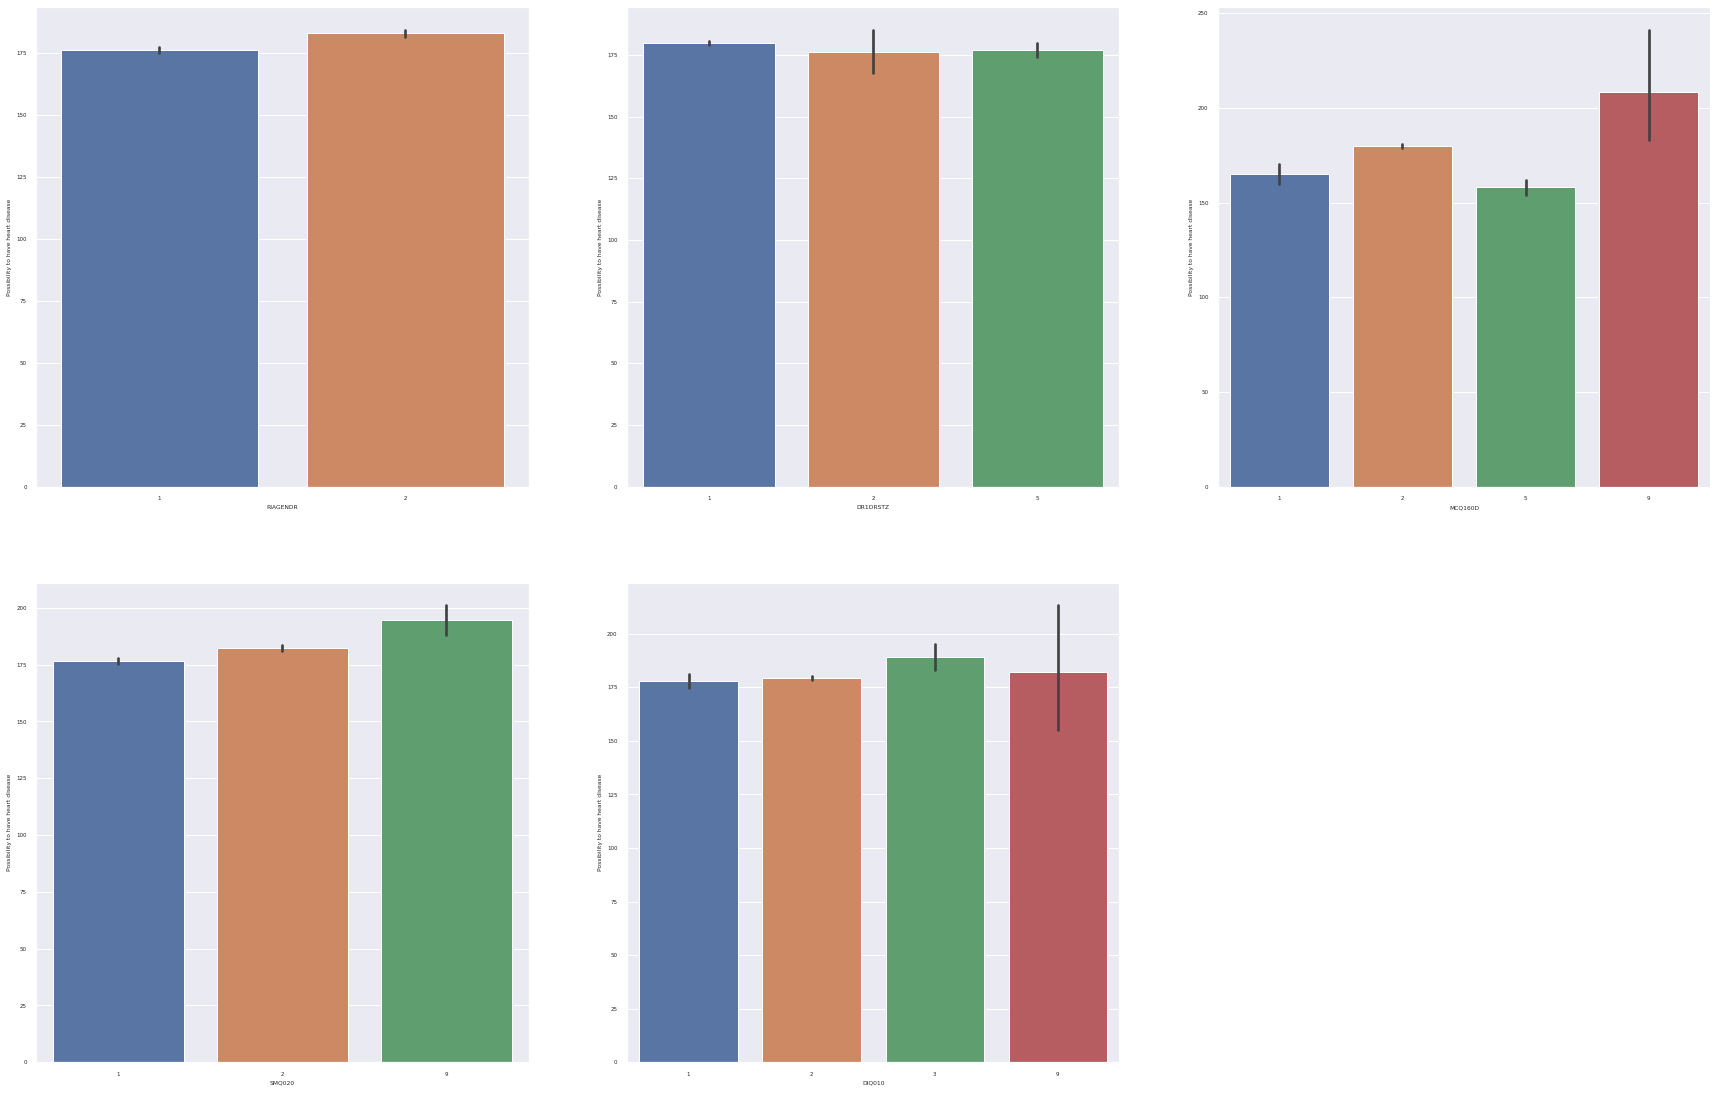

In [101]:
plt.figure(figsize=(30, 30))
for i, column in enumerate(categorical_values, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=f"{column}", y='LBXTC', data=final_df)
    plt.ylabel('Possibility to have heart disease')
    plt.xlabel(f'{column}')

In [102]:
final_df.describe()

RIDAGEYR        DRABF  ...     BMXWAIST       CDQ008
count  7624.000000  7624.000000  ...  7624.000000  7624.000000
mean     38.082371     1.998142  ...    91.644299     1.588405
std      22.450103     0.030665  ...    19.950565     0.544060
min       6.000000     1.333333  ...    46.600000     1.000000
25%      17.000000     2.000000  ...    77.700000     1.000000
50%      36.000000     2.000000  ...    91.200000     2.000000
75%      57.000000     2.000000  ...   104.500000     2.000000
max      80.000000     2.000000  ...   177.900000     9.000000

[8 rows x 31 columns]

In [103]:
categorical_columns = list(final_df.select_dtypes(include='category').columns)
numeric_columns = list(final_df.drop('LBXTC', axis=1).select_dtypes(exclude='category').columns)

DATA VISUALIZATION

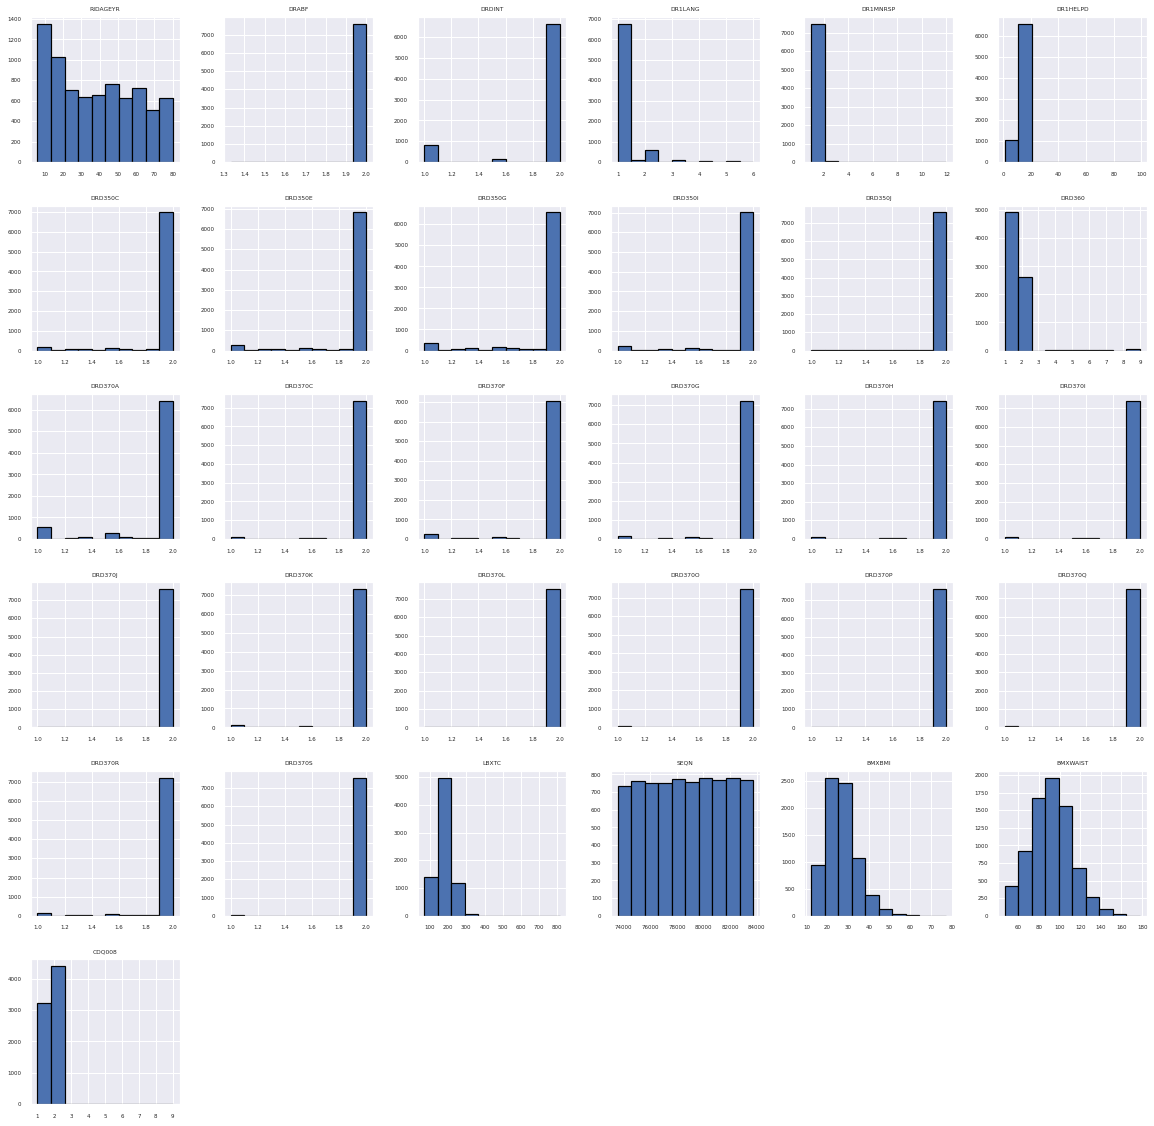

In [104]:
sns.set(font_scale=0.5)
final_df.hist(edgecolor='black', linewidth=1.2, figsize=(20, 20));

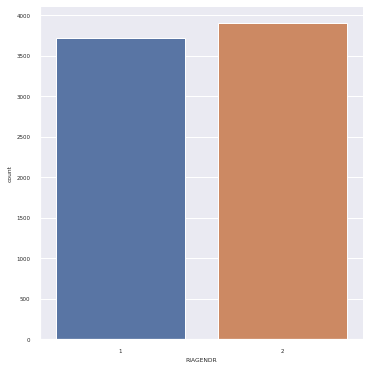

In [105]:
sns.factorplot('RIAGENDR', data=final_df, kind='count')

In [106]:
final_df["class"]=np.where(final_df["LBXTC"]<=200 ,"Good","Risk")# np.where((final_df["LBXTC"]<=239) & (final_df["LBXTC"]>200), 'Moderate', "High"))
final_df["class"].value_counts()

Good    5551
Risk    2073
Name: class, dtype: int64

SPLITTING THE DATA into TRAIN TEST 

In [107]:
x_train, x_test, y_train, y_test = train_test_split(final_df.drop(["class", 'LBXTC'],axis=1), final_df["class"],test_size=0.33, random_state=42)

In [108]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))
])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


## Applying Column Transformer
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_test = y_trans.transform(y_test)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))
feature_names = feature_names + numeric_columns

defining plots 


In [109]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [110]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs,
                                 drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [111]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [112]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [113]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [114]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [115]:
def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict,
                train_time=train_time, train_predictions=train_predictions,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

MODEL TRAINING

In [116]:
#baseline model training on XGBOOST 

In [117]:
primary_eval_metric = metrics.f1_score
confusion_lbs = ['Good', 'Risk']

## Compute `class_weights` using sklearn
cls_weight = 3696/1412

In [118]:
xgb_clf_default = XGBClassifier(random_state=42, n_jobs=-1, enable_categorical = True)
xgb_clf_default.fit(x_train, y_train);


In [119]:
pd.Series(y_train).value_counts()

0    3696
1    1412
dtype: int64

In [120]:
y_pred = xgb_clf_default.predict(x_test)

In [121]:
print(classification_report(y_test, y_pred, target_names=['Good', 'Risk']))

              precision    recall  f1-score   support

        Good       0.77      0.95      0.85      1855
        Risk       0.57      0.19      0.29       661

    accuracy                           0.75      2516
   macro avg       0.67      0.57      0.57      2516
weighted avg       0.71      0.75      0.70      2516



In [122]:
## logistic regression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_logistic_pred = clf.predict(x_test)

In [123]:
print(classification_report(y_test, y_logistic_pred, target_names=['Good', 'Risk']))

              precision    recall  f1-score   support

        Good       0.74      0.93      0.83      1855
        Risk       0.35      0.11      0.16       661

    accuracy                           0.71      2516
   macro avg       0.55      0.52      0.50      2516
weighted avg       0.64      0.71      0.65      2516



In [124]:
print(classification_report(y_train, clf.predict(x_train), target_names=['Good', 'Risk']))

              precision    recall  f1-score   support

        Good       0.74      0.93      0.83      3696
        Risk       0.45      0.14      0.21      1412

    accuracy                           0.71      5108
   macro avg       0.59      0.54      0.52      5108
weighted avg       0.66      0.71      0.66      5108



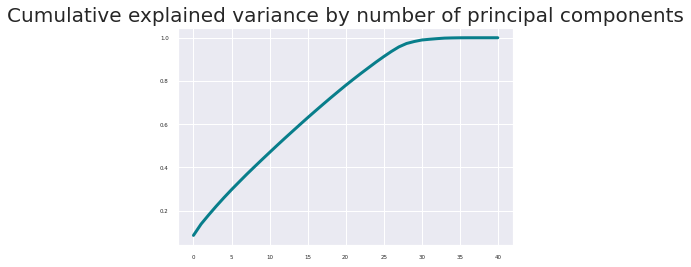

In [125]:
from sklearn.decomposition import PCA

pca = PCA().fit(x_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [126]:
xgb_clf_default.feature_importances_

array([0.21610662, 0.01681297, 0.        , 0.0375419 , 0.0220798 ,
       0.02418486, 0.02506865, 0.03230946, 0.01228329, 0.0216806 ,
       0.        , 0.01759585, 0.02004295, 0.0161851 , 0.02310908,
       0.03499167, 0.02146298, 0.02439739, 0.01100095, 0.02080135,
       0.01326694, 0.03263453, 0.        , 0.        , 0.04095399,
       0.01110694, 0.02081379, 0.0247223 , 0.04179377, 0.01874553,
       0.06590109, 0.        , 0.02798131, 0.02566269, 0.        ,
       0.        , 0.00884028, 0.        , 0.06992137, 0.        ,
       0.        ], dtype=float32)

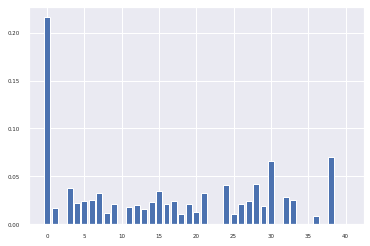

In [127]:
plt.bar(range(len(xgb_clf_default.feature_importances_)), xgb_clf_default.feature_importances_)
plt.show()

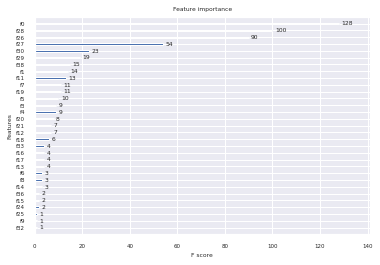

In [128]:
from matplotlib.figure import Figure
from xgboost import plot_importance
plot_importance(xgb_clf_default)
plt.show()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5108 samples
 Test Size: 2516 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.01 seconds
---------------------------------------------
Train Accuracy:  0.7613547376664056
 Test Accuracy:  0.7492050874403816
---------------------------------------------
Train F1 Score:  0.37002583979328163
 Test F1 Score:  0.28861330326944756

------------------------

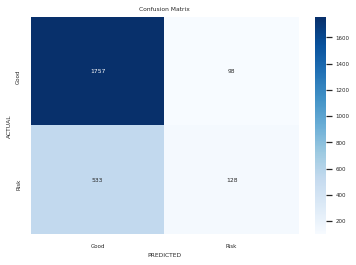


=======================================> PLOTS <=========================================


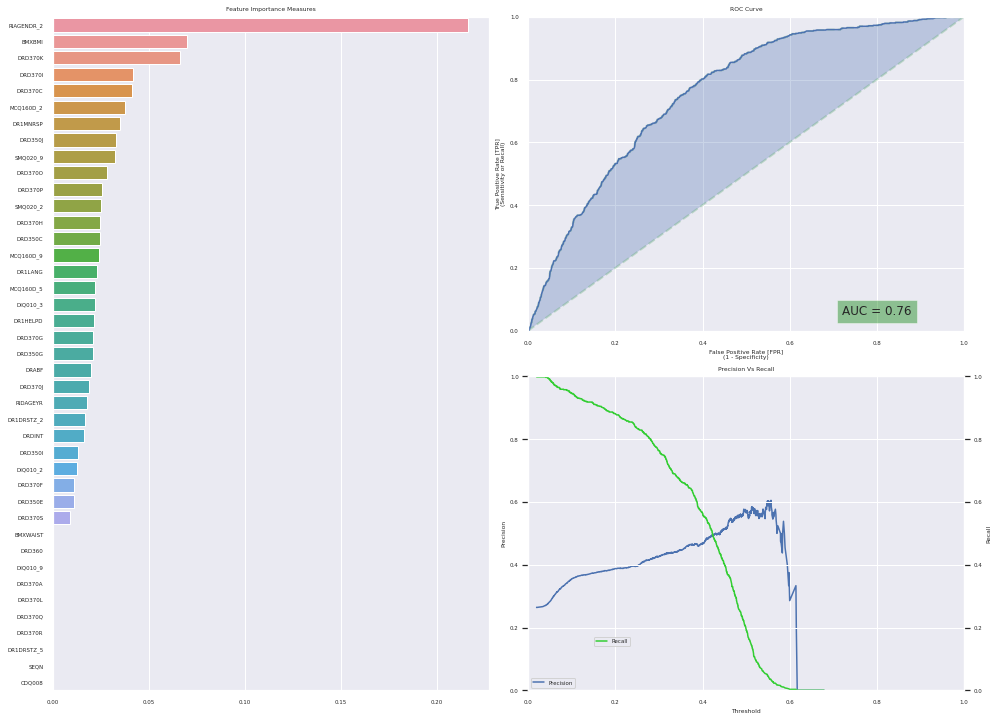

In [129]:
xgb_clf_default, xgb_report_default = report(xgb_clf_default, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)


In [130]:
!pip install optuna

In [131]:
#hyper parameter tuning 

import xgboost as xgb
import optuna
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback


def objective(trial, X, y, group, score, params=dict()):
    dtrain = xgb.DMatrix(X, label=y)
    class_weight = (y.shape[0] - np.sum(y)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgb.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]


def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial, x_train, y_train,
                                           group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params


In [132]:
score_func = metrics.f1_score
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

In [133]:
def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params

In [134]:
params = stepwise_optimization()

=========================== Optimizing Group - 1 ============================
STUDY NAME:  xgboost
------------------------------------------------
EVALUATION METRIC:  f1_score
------------------------------------------------
BEST CV SCORE 0.3697642
------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'colsample_bytree': 0.9067799644177135, 'subsample': 0.04831762255421253}
------------------------------------------------
BEST TRIAL FrozenTrial(number=111, values=[0.3697642], datetime_start=datetime.datetime(2021, 7, 11, 6, 43, 15, 190182), datetime_complete=datetime.datetime(2021, 7, 11, 6, 43, 16, 806740), params={'colsample_bytree': 0.9067799644177135, 'subsample': 0.04831762255421253}, distributions={'colsample_bytree': UniformDistribution(high=1.0, low=0.0), 'subsample': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.3840428, 1: 0.36550720000000003, 2: 0.3599366, 3: 0.384359, 4: 0.37365060000000005, 5: 0.3

In [135]:
params

{'colsample_bytree': 0.8522246260052427,
 'learning_rate': 0.05466740505106299,
 'max_depth': 10,
 'min_child_weight': 0.002106604966561311,
 'num_boost_round': 641,
 'subsample': 0.09599296006582037}

In [136]:
xgb_clf_tuned_1 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_1.fit(x_train, y_train);


In [137]:
params = stepwise_optimization(trials=50)

=========================== Optimizing Group - 1 ============================
STUDY NAME:  xgboost
------------------------------------------------
EVALUATION METRIC:  f1_score
------------------------------------------------
BEST CV SCORE 0.3813168
------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'colsample_bytree': 0.8522246260052427, 'subsample': 0.09599296006582037}
------------------------------------------------
BEST TRIAL FrozenTrial(number=193, values=[0.3813168], datetime_start=datetime.datetime(2021, 7, 11, 7, 10, 58, 13197), datetime_complete=datetime.datetime(2021, 7, 11, 7, 10, 59, 769329), params={'colsample_bytree': 0.8522246260052427, 'subsample': 0.09599296006582037}, distributions={'colsample_bytree': UniformDistribution(high=1.0, low=0.0), 'subsample': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.3949766, 1: 0.4104184, 2: 0.38270499999999996, 3: 0.37125980000000003, 4: 0.363621800000000

In [138]:
params

{'colsample_bytree': 0.8522246260052427,
 'learning_rate': 0.006850180109942785,
 'max_depth': 10,
 'min_child_weight': 21689178.9233439,
 'num_boost_round': 737,
 'subsample': 0.09599296006582037}

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8522246260052427, gamma=0,
              learning_rate=0.05466740505106299, max_delta_step=0, max_depth=10,
              min_child_weight=0.002106604966561311, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None, num_boost_round=641,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.6175637393767706, seed=None,
              silent=None, subsample=0.09599296006582037, verbosity=1)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5108 samples
 Test Size: 2516 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.028 seconds
---------------------------------------------
Train Accuracy:  0.783281127642913
 Test Accuracy:  0.6959459459459459
---------------------------------------------
Tr

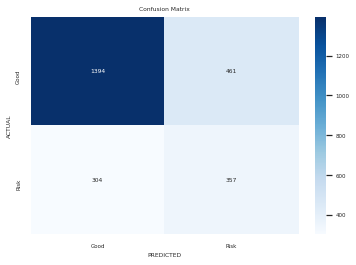


=======================================> PLOTS <=========================================


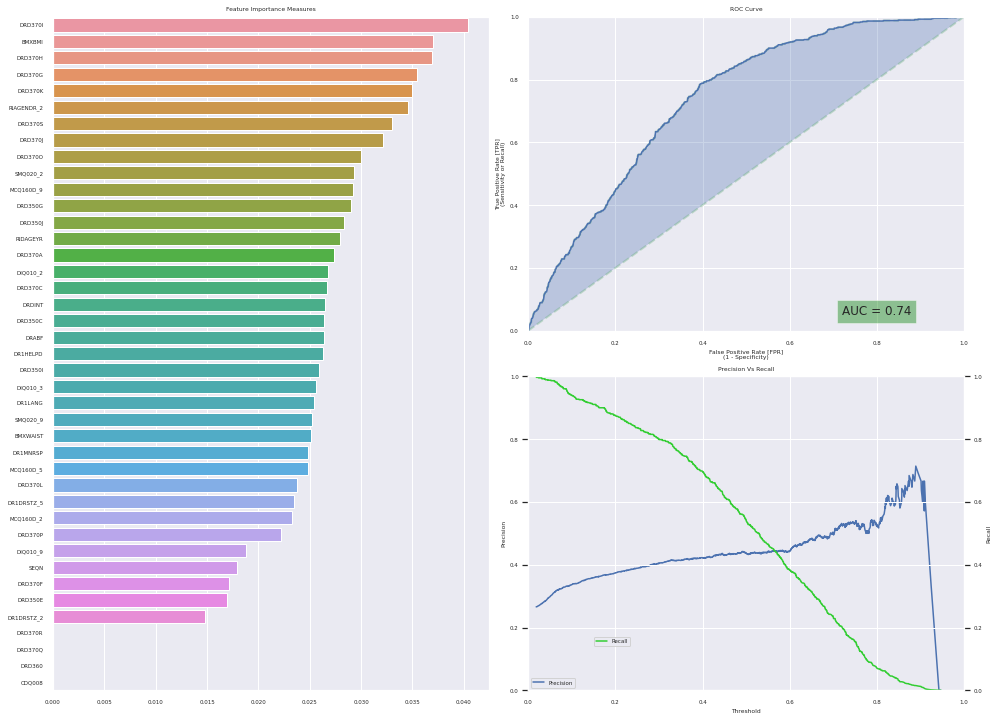

In [139]:
xgb_clf_tuned_1, xgb_report_tuned_1 = report(xgb_clf_tuned_1, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8522246260052427, gamma=0,
              learning_rate=0.006850180109942785, max_delta_step=0,
              max_depth=10, min_child_weight=21689178.9233439, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None, num_boost_round=737,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.6175637393767706, seed=None,
              silent=None, subsample=0.09599296006582037, verbosity=1)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5108 samples
 Test Size: 2516 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.002 seconds
---------------------------------------------
Train Accuracy:  0.7235708692247454
 Test Accuracy:  0.7372813990461049
---------------------------------------------
Trai

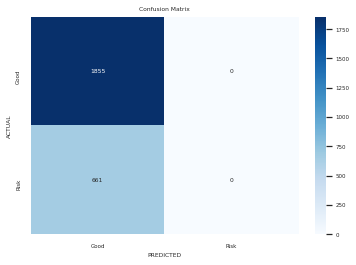


=======================================> PLOTS <=========================================


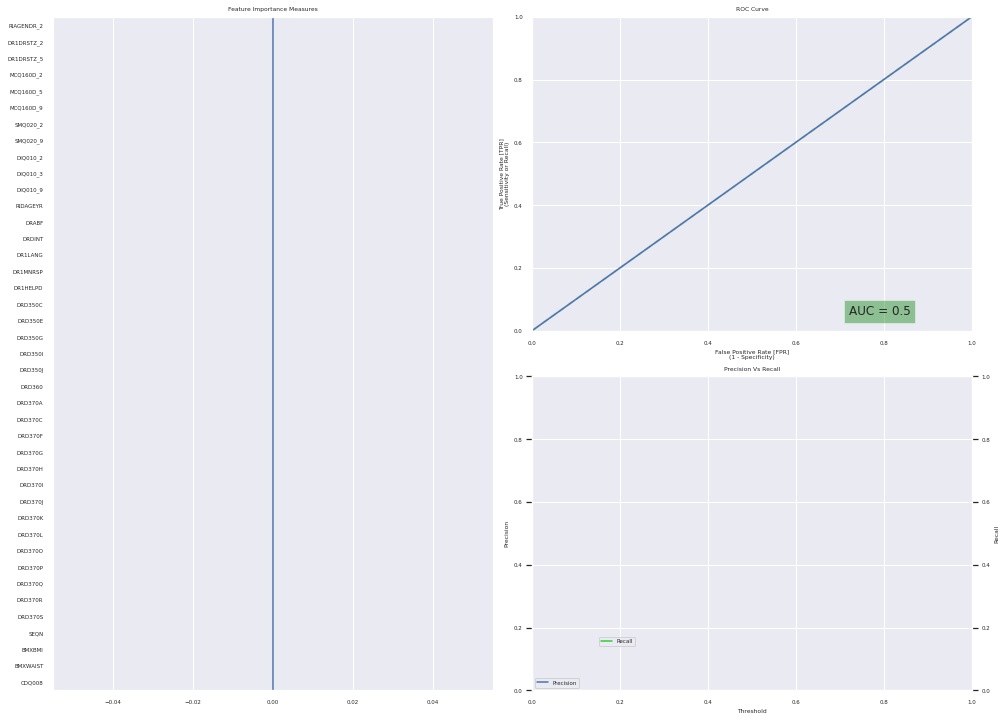

In [140]:
xgb_clf_tuned_2 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_2.fit(x_train, y_train);

xgb_clf_tuned_2, xgb_report_tuned_2 = report(xgb_clf_tuned_2, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

In [141]:
report_list = [xgb_report_default, xgb_report_tuned_1, xgb_report_tuned_2]
clf_labels = ['XGBoost with default params',
              'XGBoost after 10 trials',
              'XGBoost after 50 more trials',]

In [142]:
def compare_models(y_test=None, clf_reports=[], labels=[], score='accuracy'):
      
    ## Classifier Labels
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    clf_names =  labels if len(labels) == len(clf_reports) else default_names
    
    
    ## Compare Table
    table = dict()
    index = ['Train ' + score, 'Test ' + score, 'Overfitting', 'ROC Area',
             'Precision', 'Recall', 'F1-score', 'Support']
    for i in range(len(clf_reports)):
        scores = [round(i, 3) for i in clf_reports[i][score]]
        
        roc_auc = clf_reports[i]['roc_auc']
        
        # Get metrics of True Positive class from sklearn classification_report
        true_positive_metrics = list(clf_reports[i]['report']["1"].values())
        
        table[clf_names[i]] = scores + [scores[1] < scores[0], roc_auc] + \
                              true_positive_metrics
    
    table = pd.DataFrame(data=table, index=index)
    
    
    ## Compare Plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # ROC and Precision-Recall
    for i in range(len(clf_reports)):
        clf_probs = clf_reports[i]['test_probs']
        roc_plot(y_test, clf_probs, label=clf_names[i],
                 compare=True, ax=axes[0])
        precision_recall_plot(y_test, clf_probs, label=clf_names[i],
                              compare=True, ax=axes[1])
    # Plot No-Info classifier
    axes[0].plot([0,1], [0,1], linestyle='--', color='green')
        
    fig.tight_layout()
    plt.close()
    
    return table.T, fig

In [143]:
compare_table, compare_plot = compare_models(y_test, clf_reports=report_list,
                                             labels=clf_labels,
                                             score=primary_eval_metric.__name__)

compare_table

Train f1_score Test f1_score  ...  F1-score Support
XGBoost with default params            0.37         0.289  ...  0.288613     661
XGBoost after 10 trials               0.649         0.483  ...  0.482759     661
XGBoost after 50 more trials              0             0  ...         0     661

[3 rows x 8 columns]

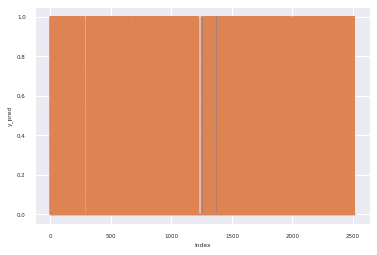

In [144]:
final_df = pd.DataFrame()
final_df['y_test']=y_test
final_df['y_pred']=y_pred
final_df['index'] = final_df.index
sns.lineplot(data=final_df, x= "index", y="y_pred")
sns.lineplot(data=final_df, x= "index", y="y_test")

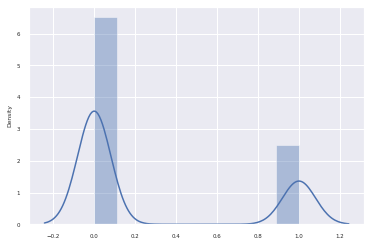

In [145]:
sns.distplot(y_train)

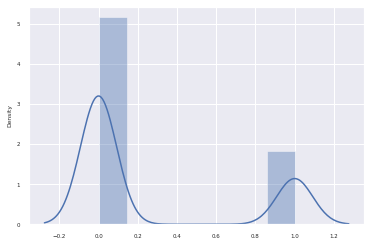

In [146]:
sns.distplot(y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.63,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5108 samples
 Test Size: 2516 samples
---------------------------------------------
Training Time: 0.358 seconds
 Testing Time: 0.103 seconds
---------------------------------------------
Train Accuracy:  0.6213782302270947
 Test Accuracy:  0.6116852146263911
---------------------------------------------
Train F1 Score:  0.541923259118901
 Test F1

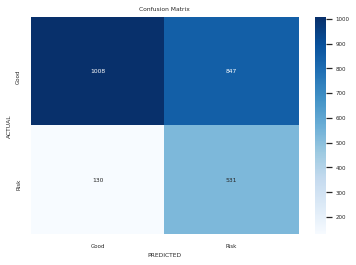


=======================================> PLOTS <=========================================


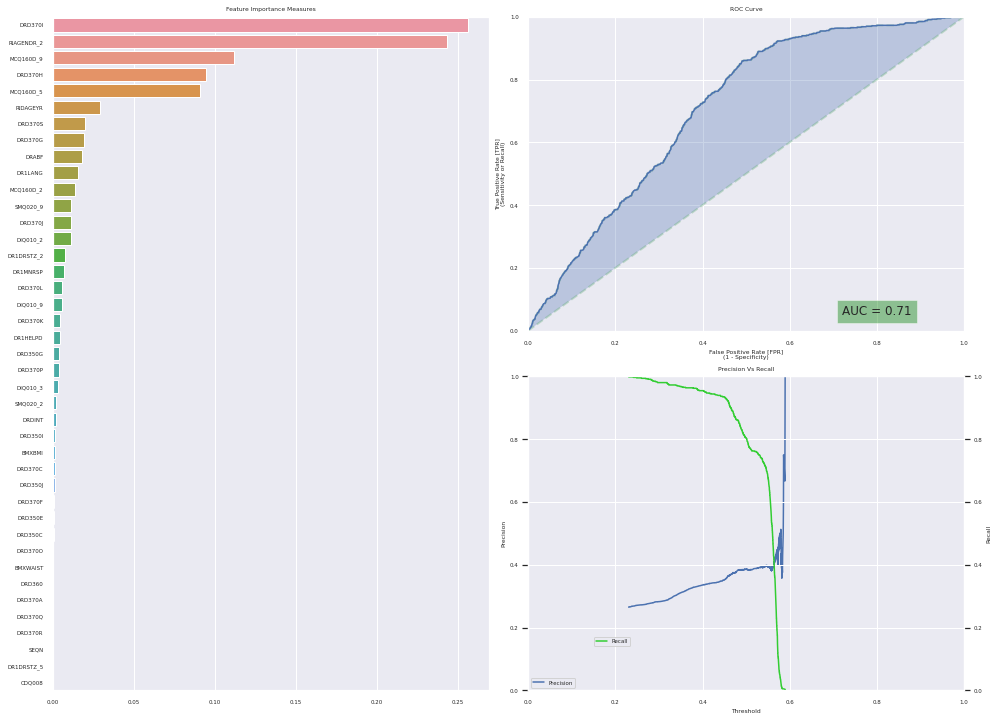

In [147]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                       max_depth=2, max_samples=0.63, n_estimators=100,
                                       n_jobs=-1, random_state=seed_val)

random_forest, random_forest_report = report(random_forest, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

In [148]:
!pip install shap

In [149]:
import shap

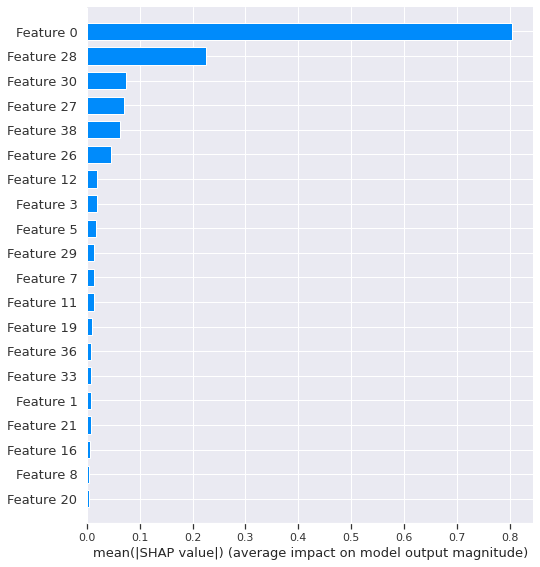

In [152]:
explainer = shap.TreeExplainer(xgb_clf_default)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [154]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test[0,:100])

In [157]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train)

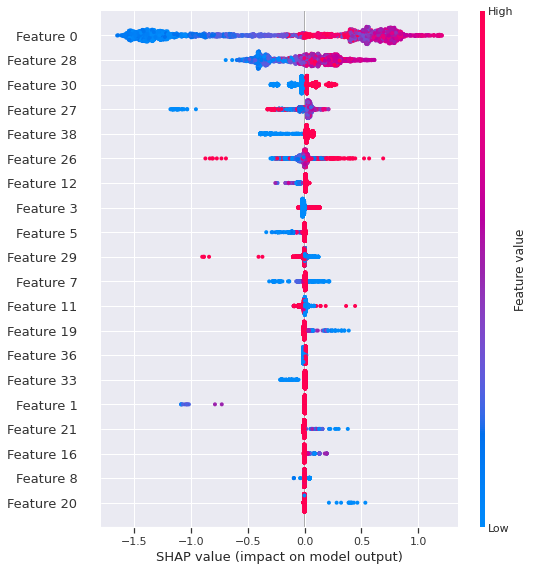

In [159]:
shap.initjs()
shap.summary_plot(shap_values, x_test)

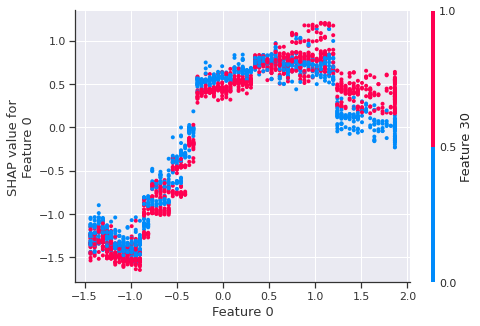

In [168]:
shap.initjs()
shap.dependence_plot('Feature 0', shap_values, x_test)

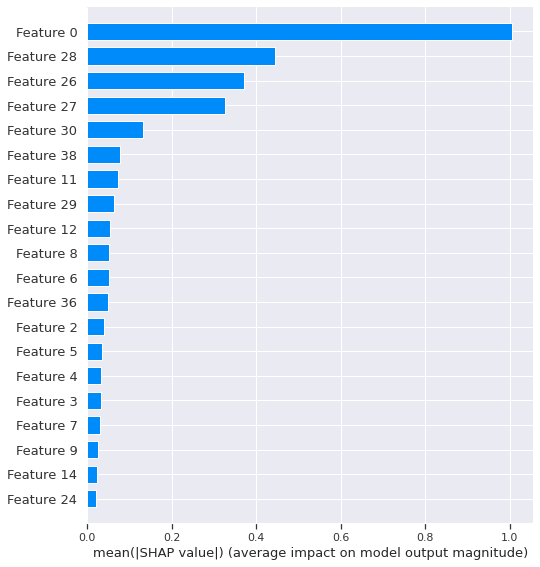

In [169]:
explainer = shap.TreeExplainer(xgb_clf_tuned_1)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

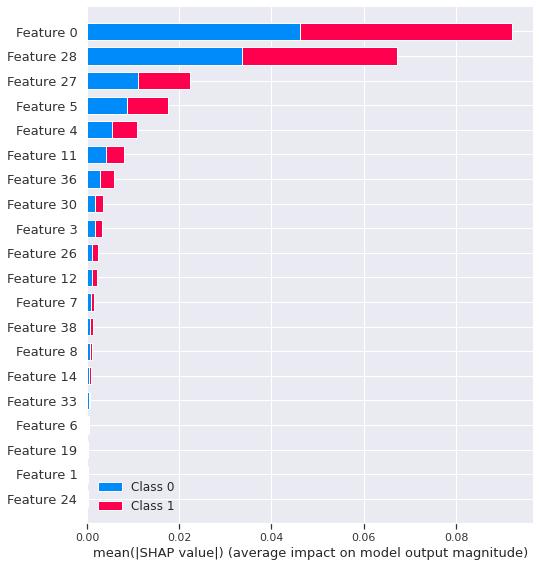

In [171]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")